In [1]:
# enable cuda
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
content_path='C:\\Users\\skyxt\\OneDrive - The University of Chicago\\ADSP 32023 Advanaced Computer Vision with Deep Learning\\Final Project\\Google Scraped Image Dataset\\images\\images\\food and drinks\\0 (3).jpg'
style_path = 'C:\\Users\\skyxt\\OneDrive - The University of Chicago\\ADSP 32023 Advanaced Computer Vision with Deep Learning\\Final Project\\Best Artworks of All Time\\images\\images\\Pablo_Picasso\\Pablo_Picasso_316.jpg'

In [4]:
def load_file(image_path):
    image = Image.open(image_path)
    max_dim = 512
    factor = max_dim / max(image.size)
    image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.Resampling.LANCZOS)
    im_array = img_to_array(image)
    im_array = np.expand_dims(im_array, axis=0)  # Adding extra axis to the array to generate a batch of single image
    return im_array

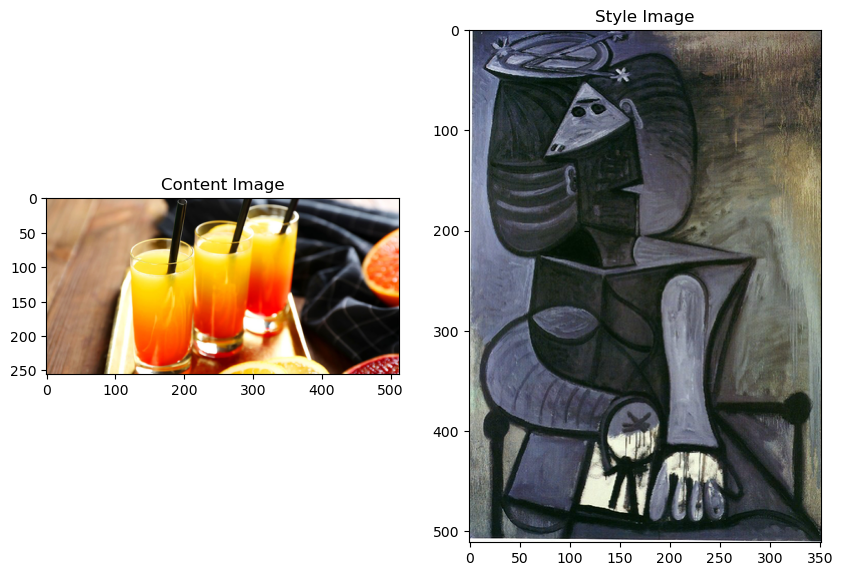

In [5]:
# Assuming content_path and style_path are defined
content = load_file(content_path)
style = load_file(style_path)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(content[0].astype('uint8'))  # Adjust for display
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style[0].astype('uint8'))  # Adjust for display
plt.title('Style Image')
plt.show()

In [6]:
# def img_preprocess(img_path):
#     image=load_file(img_path)
#     img=tf.keras.applications.vgg19.preprocess_input(image)
#     return img

def img_preprocess(img_path):
    image = load_file(img_path)
    
    # Resize image to match the input size of the model
    target_size = (224, 224)
    image = tf.image.resize(image, target_size)

    # Preprocess the image as required by VGG19
    img = tf.keras.applications.vgg19.preprocess_input(image)
    return img


def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [7]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    print("Image shape before model forward pass in compute_loss:", image.shape)
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [8]:
def create_custom_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # # Classification block
    # model.add(Flatten())
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dense(4096, activation='relu'))
    # model.add(Dense(1000, activation='softmax')) # 1000 for ImageNet

    return model

model = create_custom_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [9]:

# choose the layers to extract features from
content_layers = ['conv2d_8']  # Adjusted to your model's naming convention
style_layers = ['conv2d', 'conv2d_2', 'conv2d_4', 'conv2d_7', 'conv2d_10']  # Adjusted to your model's naming convention


number_content=len(content_layers)
number_style =len(style_layers)

In [10]:
def get_model():
    content_output=[model.get_layer(layer).output for layer in content_layers]
    style_output=[model.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(model.input,model_output)

In [11]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    # for layer in model.layers:
    #     layer.trainable = True
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    # noise = img_preprocess(content_path)
    # noise=tf.Variable(noise,dtype=tf.float32)

    noise = img_preprocess(content_path)
    # Resize the noise image to match the input size of the model
    noise = tf.image.resize(noise, (224, 224))
    print("Noise image shape after resize:", noise.shape)
    noise = tf.Variable(noise, dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [ ]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=2000)

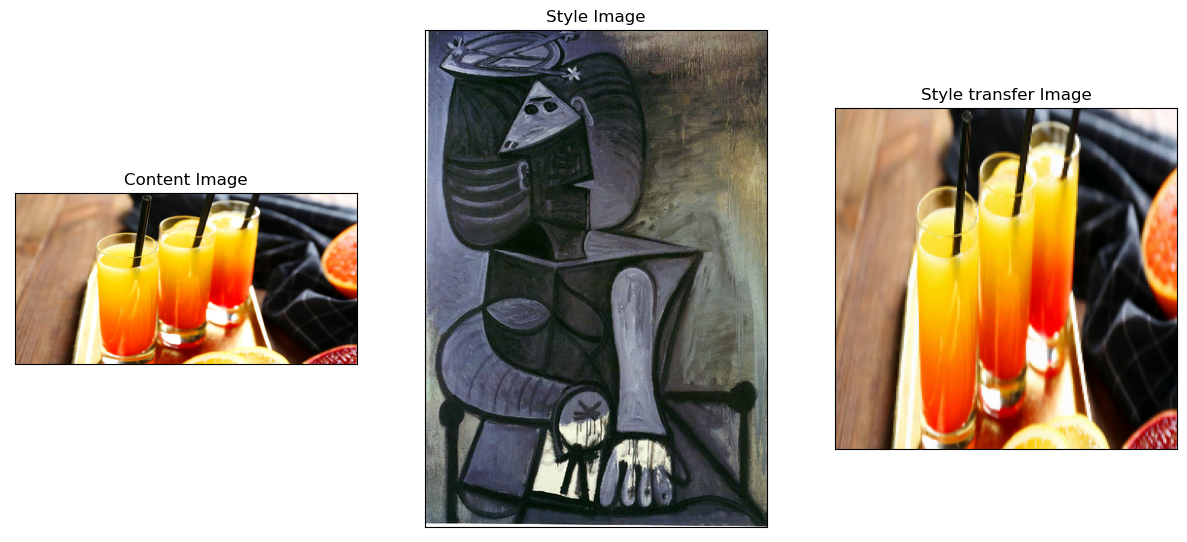

In [ ]:

plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()